# Применение сингулярных разложений для обнаружения выбросов в данных о потреблении контента

Подробный текст исследования читайте [в формате pdf](paper.pdf).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import sklearn.model_selection as sklm

## Чтение данных

Поскольку исходные данные являются сырыми, приходится повозиться, прежде чем получается удобоваримый датафрейм.

In [2]:
df = pd.read_csv('data/data.csv', parse_dates = ['Дата'])
df = df.drop(index = [0, 501])
df['Процент лайков'] = df['Процент отметок "Нравится" (%)']
df['Дизлайки'] = df['Отметки "Не нравится"']
df['Лайки'] = df['Отметки "Нравится"']
df = df.drop(columns = ['Процент отметок "Нравится" (%)', 'Отметки "Не нравится"', 'Отметки "Нравится"'])
df.to_csv('d.csv', index = False)
df = pd.read_csv('data/d.csv', parse_dates = ['Дата'])
df.index = df['Дата']
df = df.drop(columns = ['Дата'])
df = df.drop(columns = ['Опубликованные видео', 'Добавленные видео', 'Средняя продолжительность просмотра'])
df['Средняя продолжительность просмотра'] = 3600*df['Время просмотра (часы)']/df['Просмотры']
df = df.fillna(0)
df

df = df[['Просмотры', 
         'Время просмотра (часы)', 
         'Поделились', 
         'Постоянные зрители',
         'Новые комментарии', 
         'Отказались от подписки',       
         'Новые подписчики',  
         'Новые зрители',       
         'Среднее число просмотров одним пользователем', 
         'Уникальные зрители',       
         'CTR для значков видео (%)', 
         'Показы', 
         'Подписчики',       
         'Средний процент просмотра (%)',        
         'Процент лайков',        
         'Средняя продолжительность просмотра',
         'Дизлайки', 
         'Лайки'
        ]]

df

,Просмотры,Время просмотра (часы),Поделились,Постоянные зрители,Новые комментарии,Отказались от подписки,Новые подписчики,Новые зрители,Среднее число просмотров одним пользователем,Уникальные зрители,CTR для значков видео (%),Показы,Подписчики,Средний процент просмотра (%),Процент лайков,Средняя продолжительность просмотра,Дизлайки,Лайки
Дата,,,,,,,,,,,,,,,,,,
2023-01-01,475.0,21.2038,9.0,84.0,0.0,5.0,5.0,144.0,2.0833,228.0,4.25,5176.0,0.0,30.51,100.00,160.702484,0.0,16.0
2022-12-31,174.0,5.4814,1.0,48.0,0.0,1.0,1.0,60.0,1.6111,108.0,4.05,2222.0,0.0,19.52,100.00,113.408276,0.0,4.0
2022-12-30,490.0,17.8182,3.0,94.0,0.0,1.0,1.0,133.0,2.1586,227.0,5.27,5584.0,0.0,23.51,75.00,130.909224,1.0,3.0
2022-12-29,665.0,25.9174,10.0,128.0,1.0,2.0,1.0,231.0,1.8524,359.0,5.78,6759.0,-1.0,25.35,100.00,140.304722,0.0,8.0
2022-12-28,971.0,35.3850,4.0,166.0,0.0,3.0,7.0,362.0,1.8390,528.0,7.04,6736.0,4.0,21.72,85.71,131.190525,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24,287.0,16.8233,0.0,55.0,0.0,0.0,4.0,97.0,1.8882,152.0,3.99,3156.0,4.0,41.29,90.91,211.023972,1.0,10.0
2021-08-23,310.0,17.3132,0.0,47.0,0.0,4.0,4.0,89.0,2.2794,136.0,3.99,4359.0,0.0,40.61,85.71,201.056516,1.0,6.0
2021-08-22,275.0,10.4130,1.0,44.0,0.0,1.0,4.0,63.0,2.5701,107.0,4.00,4176.0,3.0,26.91,100.00,136.315636,0.0,2.0


### Разведочный анализ

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2023-01-01 to 2021-08-20
Data columns (total 18 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Просмотры                                     500 non-null    float64
 1   Время просмотра (часы)                        500 non-null    float64
 2   Поделились                                    500 non-null    float64
 3   Постоянные зрители                            500 non-null    float64
 4   Новые комментарии                             500 non-null    float64
 5   Отказались от подписки                        500 non-null    float64
 6   Новые подписчики                              500 non-null    float64
 7   Новые зрители                                 500 non-null    float64
 8   Среднее число просмотров одним пользователем  500 non-null    float64
 9   Уникальные зрители                            

## Разделение объектов на обучающую и тестовую выборки

In [4]:
df_train, df_test = sklm.train_test_split(df, test_size=0.2)

## Нормализация обучающей выборки

In [5]:
# Смотрим на характеристики признаков
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Просмотры,400.0,935.962500,423.199297,126.000000,665.250000,963.500000,1236.500000,2200.000000
Время просмотра (часы),400.0,37.186787,16.992440,4.698900,25.353000,37.700650,48.660200,96.729900
Поделились,400.0,7.062500,6.621798,0.000000,3.000000,6.000000,10.000000,71.000000
Постоянные зрители,400.0,162.975000,79.544123,21.000000,114.000000,161.000000,206.000000,463.000000
Новые комментарии,400.0,0.552500,0.856784,0.000000,0.000000,0.000000,1.000000,6.000000
Отказались от подписки,400.0,2.970000,5.277189,0.000000,1.000000,2.000000,4.000000,95.000000
Новые подписчики,400.0,6.522500,3.450254,0.000000,4.000000,6.000000,9.000000,19.000000
Новые зрители,400.0,364.175000,172.910162,46.000000,239.500000,361.500000,509.500000,735.000000
Среднее число просмотров одним пользователем,400.0,1.801793,0.225175,1.315800,1.637500,1.771200,1.919275,3.048900
Уникальные зрители,400.0,527.147500,239.046751,70.000000,375.750000,532.000000,709.250000,1103.000000


In [6]:
# Собственно нормализация
X_train = (df_train - df_train.mean())/df_train.std()

# Смотрим на характеристики после нормализации
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Просмотры,400.0,5.773160e-17,1.0,-1.913903,-0.639681,0.065070,0.710156,2.986861
Время просмотра (часы),400.0,-1.931788e-16,1.0,-1.911902,-0.696415,0.030241,0.675207,3.504094
Поделились,400.0,-8.881784e-18,1.0,-1.066553,-0.613504,-0.160455,0.443611,9.655610
Постоянные зрители,400.0,7.993606e-17,1.0,-1.784858,-0.615696,-0.024829,0.540895,3.771806
Новые комментарии,400.0,-8.881784e-18,1.0,-0.644853,-0.644853,-0.644853,0.522302,6.358078
Отказались от подписки,400.0,-4.884981e-17,1.0,-0.562800,-0.373305,-0.183810,0.195180,17.439209
Новые подписчики,400.0,-4.440892e-18,1.0,-1.890440,-0.731106,-0.151438,0.718063,3.616400
Новые зрители,400.0,-5.107026e-17,1.0,-1.840117,-0.721039,-0.015470,0.840465,2.144611
Среднее число просмотров одним пользователем,400.0,-7.283063e-16,1.0,-2.158290,-0.729623,-0.135862,0.521738,5.538394
Уникальные зрители,400.0,-1.532108e-16,1.0,-1.912377,-0.633338,0.020299,0.761786,2.408953


## Сингулярное разложение матрицы обучающих данных

### Вывод массива numpy из датафрейма df_train

In [7]:
X_train = X_train.to_numpy()

### Сингулярное разложение

In [8]:
# Проводим SVD. На выходе три массива
U, Sigma, V = np.linalg.svd(X_train, full_matrices=False)

### Переход к сингулярному базису

In [9]:
# Выполняем матричное умножение
S_train = np.dot(X_train, V.T)

## Проекция обучающих данных на первое главное направление

In [10]:
S_train_reduce = np.concatenate((S_train[:, :1], np.zeros((len(S_train), np.shape(S_train)[1]-1))), axis=1)
X_train_reduce = np.dot(S_train_reduce, V)

## Реконструкционная ошибка

In [11]:
# Вычисляем расстояния между точками
reconstruction_error_train = np.linalg.norm(X_train - X_train_reduce, axis=1)

## Порог отсечения

In [12]:
# K -- процент данных, которыми мы готовы пожертвовать
K = 2
threshold_train = np.percentile(reconstruction_error_train, 100 - K)

## Выбросы обучающей выборки

In [13]:
# Получаем индексы того, что является выбросами (на этом пороге отсечения)
anomaly_indices_train = np.where(reconstruction_error_train > threshold_train)

## Нормализация тестовой выборки

In [14]:
# Нормализуем тест по характеристикам трейна
X_test = (df_test - df_train.mean())/df_train.std()
X_test = X_test.to_numpy()

## Реконструкционная  ошибка тестовых данных

In [15]:
S_test = np.dot(X_test, V.T)
S_test_reduce = np.concatenate((S_test[:, :1], np.zeros((len(S_test), np.shape(S_test)[1]-1))), axis=1)
X_test_reduce = np.dot(S_test_reduce, V)

reconstruction_error_test = np.linalg.norm(X_test - X_test_reduce, axis=1)

## Выбросы в тестовой выборке

In [16]:
# Индексы аномалий на тесте
anomaly_indices_test = np.where(reconstruction_error_test > threshold_train)

## Результаты

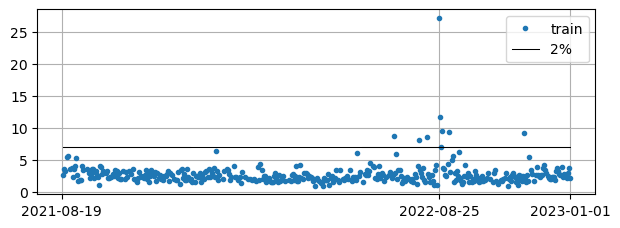

DatetimeIndex(['2022-08-05', '2022-08-28', '2022-08-25', '2022-09-04',
               '2022-08-26', '2022-08-13', '2022-11-17', '2022-07-12'],
              dtype='datetime64[ns]', name='Дата', freq=None)


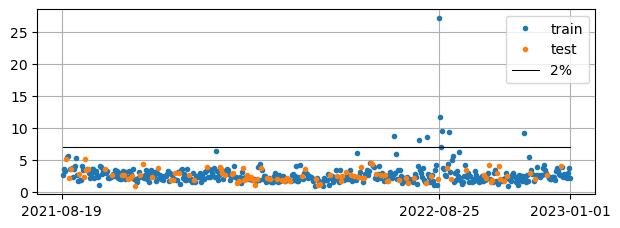

DatetimeIndex([], dtype='datetime64[ns]', name='Дата', freq=None)


In [17]:
#
# А здесь сводим все (кроме чтения данных) в одну ячейку, прогоняем еще раз и рисуем две картинки
#
df_train, df_test = sklm.train_test_split(df, test_size=0.2)
X_train = (df_train - df_train.mean())/df_train.std()
X_train = X_train.to_numpy()

# K -- процент данных, которыми мы готовы пожертвовать

K = 2

U, Sigma, V = np.linalg.svd(X_train, full_matrices=False)
S_train = np.dot(X_train, V.T)
S_train_reduce = np.concatenate((S_train[:, :1], np.zeros((len(S_train), np.shape(S_train)[1]-1))), axis=1)
X_train_reduce = np.dot(S_train_reduce, V)

reconstruction_error_train = np.linalg.norm(X_train - X_train_reduce, axis=1)
threshold_train = np.percentile(reconstruction_error_train, 100 - K)
anomaly_indices_train = np.where(reconstruction_error_train > threshold_train)

X_test = (df_test - df_train.mean())/df_train.std()
X_test = X_test.to_numpy()

S_test = np.dot(X_test, V.T)
S_test_reduce = np.concatenate((S_test[:, :1], np.zeros((len(S_test), np.shape(S_test)[1]-1))), axis=1)
X_test_reduce = np.dot(S_test_reduce, V)

reconstruction_error_test = np.linalg.norm(X_test - X_test_reduce, axis=1)
anomaly_indices_test = np.where(reconstruction_error_test > threshold_train)

df_train['Ошибка объекта'] = reconstruction_error_train
df_test['Ошибка объекта'] = reconstruction_error_test

df_er = pd.concat([df_train, df_test])

df_er['Порог'] = threshold_train


plt.figure(figsize = (7.2, 2.4))
plt.grid()
plt.plot(df_train['Ошибка объекта'], '.', label = 'train')
plt.plot(df_er['Порог'], '-', color = 'black', linewidth = 0.75, label = str(K)+'%')
ticks = ['2021-08-19', '2022-08-25', '2023-01-01']
plt.xticks(ticks)
plt.legend()

#plt.savefig('train.png', dpi = 300, bbox_inches = 'tight')

plt.show()

print(df_train.iloc[anomaly_indices_train].index)

plt.figure(figsize = (7.2, 2.4))
plt.grid()
plt.plot(df_train['Ошибка объекта'], '.', label = 'train')
plt.plot(df_test['Ошибка объекта'], '.', label = 'test')
plt.plot(df_er['Порог'], '-', color = 'black', linewidth = 0.75, label = str(K)+'%')
ticks = ['2021-08-19', '2022-08-25', '2023-01-01']
plt.xticks(ticks)
plt.legend()

#plt.savefig('test.png', dpi = 300, bbox_inches = 'tight')

plt.show()

print(df_test.iloc[anomaly_indices_test].index)